# Explore Session Data

## Variable Description 
- user_id: to be joined with the column 'id' in users table
- action_type: depth 1 action description
- action_detail: depth 2 action description
- action: depth 3 action description
- device_type
- secs_elapsed

## Summary of the exploratory analysis

Basic:
- 10M data of users for 2014.
- Jan-Jun: train users, Jul-Sep: test users. 
- each row is a single action by a user, with 3 hierarchical descriptions of action (action type - action detail - action)
  with seconds spent. 
- 11 action types, 156 action details, and 360 actions. 
- 65K out of 210K train users have session data. 
- Almost all(99.3%) of 62K test users have session data. 
- ~10% of data have missing information.  

Observation:
- User actions are unbalanced in terms of number of actions and total seconds.   
- There is a general trend that the booking rate increases as the number of actions, total seconds, and average sec per actions increase. 

Clustering:
- We expect that users is grouped by 'guest', 'host', 'both', 'no action yet'.
- We apply k-Means clustering with n=4. 
- We need to investigate more to get better insight

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_s = pd.read_csv('sessions.csv')

In [3]:
df_s.shape

(10567737, 6)

In [4]:
df_s.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [5]:
df_s.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

- 10% of action_type and action_details are missing. 
- others are ~1% missing. 

# 1. hierarchical action values

In [6]:
len(df_s.action_type.unique())

11

In [7]:
df_s.action_type.value_counts()[:10]

view                3560902
data                2103770
click               1996183
-unknown-           1031170
submit               623357
message_post          87103
partner_callback      19132
booking_request       18773
modify                 1139
booking_response          4
Name: action_type, dtype: int64

In [8]:
len(df_s.action_detail.unique())

156

In [9]:
df_s.action_detail.value_counts()[:10]

view_search_results            1776885
p3                             1376550
-unknown-                      1031141
wishlist_content_update         706824
user_profile                    656839
change_trip_characteristics     487744
similar_listings                364624
user_social_connections         336799
update_listing                  269779
listing_reviews                 269021
Name: action_detail, dtype: int64

In [10]:
len(df_s.action.unique())

360

In [11]:
df_s.action.value_counts()[:10]

show                     2768278
index                     843699
search_results            725226
personalize               706824
search                    536057
ajax_refresh_subtotal     487744
update                    365130
similar_listings          364624
social_connections        339000
reviews                   320591
Name: action, dtype: int64

# 2. example of user actions

- We manually investigate several user actions from train data.  

## example of actions of booked-users

In [12]:
ids_nobook = ['cqoo2tmnwk', 'e3b7a3l1ph']
ids_book = ['fe24xftr8v', 'wd8g0cqs1q']

In [13]:
df_s[df_s.user_id == 'fe24xftr8v'].action.value_counts()

show                           24
personalize                    17
similar_listings               14
ajax_refresh_subtotal          13
search_results                  9
calendar_tab_inner2             8
track_page_view                 3
other_hosting_reviews_first     3
index                           2
cancellation_policies           2
my                              2
update                          1
other_hosting_reviews           1
create                          1
open_graph_setting              1
header_userpic                  1
listings                        1
Name: action, dtype: int64

In [14]:
df_s[df_s.user_id == 'wd8g0cqs1q'].action.value_counts()

search_results           21
show                     18
index                     8
personalize               7
ajax_refresh_subtotal     6
similar_listings          6
update                    2
requested                 2
create                    2
cancellation_policies     2
dashboard                 2
pending                   1
verify                    1
confirm_email             1
header_userpic            1
Name: action, dtype: int64

## example of actions of no-booked users

In [15]:
df_s[df_s.user_id == 'cqoo2tmnwk'].action.value_counts()

show                     2
confirm_email            2
personalize              2
dashboard                2
ajax_refresh_subtotal    1
authenticate             1
open_graph_setting       1
cancellation_policies    1
header_userpic           1
update                   1
Name: action, dtype: int64

In [16]:
df_s[df_s.user_id == 'e3b7a3l1ph'].action.value_counts()

ask_question    1
Name: action, dtype: int64

- Even based on only 4 examples, we can see that booked users have more actions.

# 3. number of actions

- We analyze the relation between number of total actions and bookings. 

In [17]:
df_merged = pd.read_csv('train_user_session_merged.csv')
actions = pd.read_csv('actions.csv', header=None, names=['action']).action.tolist()

In [18]:
df = df_merged[['id', 'n_action', 'total_sec', 'avg_sec_per_action', 'country_destination']].copy()

In [19]:
df.head()

,id,n_action,total_sec,avg_sec_per_action,country_destination
0,yo8nz8bqcq,9,207842.0,23093.555556,NDF
1,4grx6yxeby,16,1135444.0,70965.250000,NDF
2,ncf87guaf0,152,3755100.0,24704.605263,NDF
3,c8mfesvkv0,3,1380288.0,460096.000000,NDF
4,xwxei6hdk4,7,49673.0,7096.142857,US


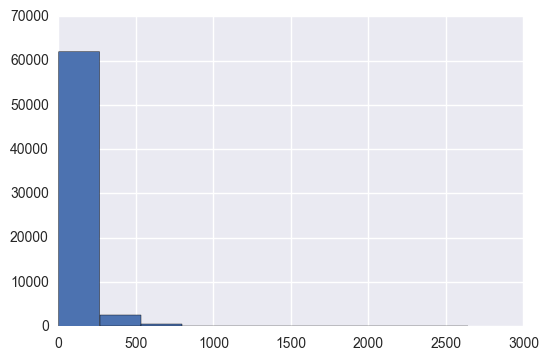

In [20]:
df.n_action.hist()

- We see that most users (~90%) have < 200 n_action, while maximum is 2644. 
- The number of actions is highly unbalanced. 

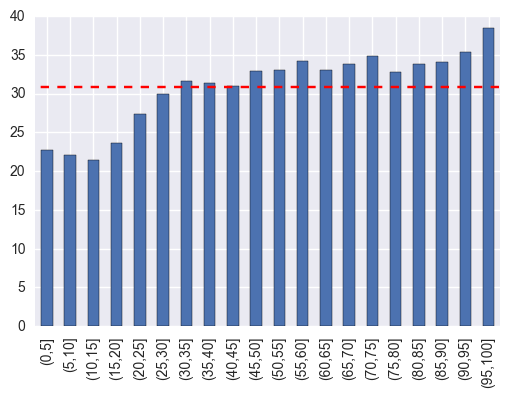

In [21]:
n_action_quantile = df.n_action.quantile(np.linspace(0,1,21))
labels = ['(%d,%d]' %(5*i, 5*i+5) for i in range(len(n_action_quantile)-1)]
df['n_action_quantile'] = pd.cut(df['n_action'], bins=n_action_quantile, labels=labels)

gp = df.groupby('n_action_quantile')
labels = []
rates = []
for label, df_gp in gp:
    cnt = df_gp.country_destination.value_counts()
    booking_rate = (cnt/cnt.sum())['US']*100
    labels.append(label)
    rates.append(booking_rate)
    
quantile_rate = pd.Series(rates, index=labels)
quantile_rate.plot(kind='bar')
plt.plot([-1,22],[30.8,30.8],'r--')

- We see the general trend of the increase in booking rate as the number of actions increase.

# 4. Total seconds / Average seconds on actions

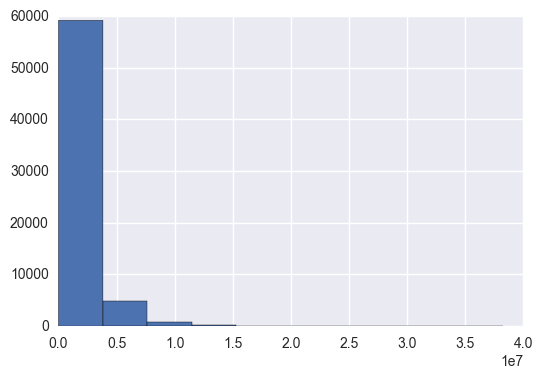

In [22]:
df.total_sec.hist()

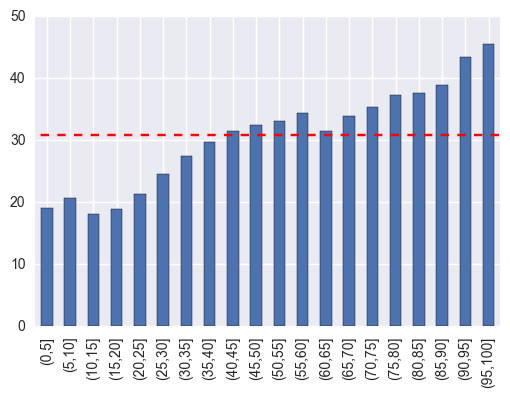

In [23]:
total_sec_quantile = df.total_sec.quantile(np.linspace(0,1,21))
labels = ['(%d,%d]' %(5*i, 5*i+5) for i in range(len(total_sec_quantile)-1)]
df['total_sec_quantile'] = pd.cut(df['total_sec'], bins=total_sec_quantile, labels=labels)

gp = df.groupby('total_sec_quantile')
labels = []
rates = []
for label, df_gp in gp:
    cnt = df_gp.country_destination.value_counts()
    booking_rate = (cnt/cnt.sum())['US']*100
    labels.append(label)
    rates.append(booking_rate)
    
quantile_rate = pd.Series(rates, index=labels)
quantile_rate.plot(kind='bar')
plt.plot([-1,22],[30.8,30.8],'r--')

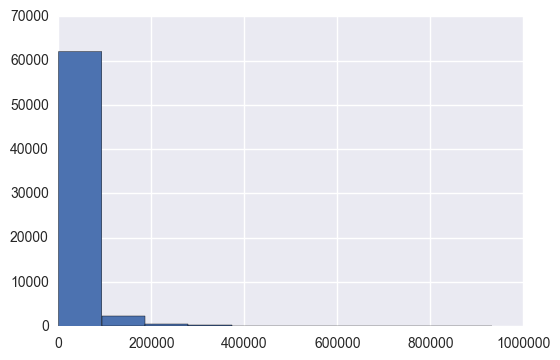

In [24]:
df.avg_sec_per_action.hist()

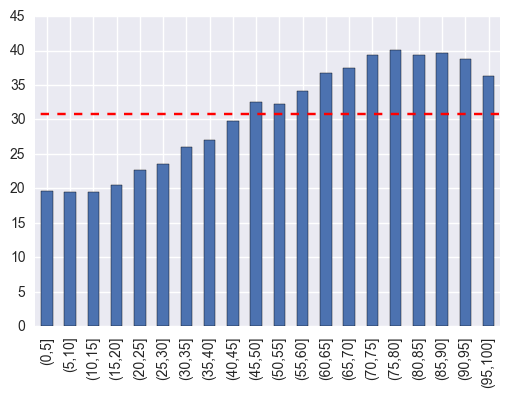

In [25]:
avg_sec_quantile = df.avg_sec_per_action.quantile(np.linspace(0,1,21))
labels = ['(%d,%d]' %(5*i, 5*i+5) for i in range(len(avg_sec_quantile)-1)]
df['avg_sec_quantile'] = pd.cut(df['avg_sec_per_action'], bins=avg_sec_quantile, labels=labels)

gp = df.groupby('avg_sec_quantile')
labels = []
rates = []
for label, df_gp in gp:
    cnt = df_gp.country_destination.value_counts()
    booking_rate = (cnt/cnt.sum())['US']*100
    labels.append(label)
    rates.append(booking_rate)
    
quantile_rate = pd.Series(rates, index=labels)
quantile_rate.plot(kind='bar')
plt.plot([-1,22],[30.8,30.8],'r--')

# Clustering

In [26]:
from sklearn.cluster import KMeans

X = df_merged[actions]

In [27]:
kmeans = KMeans(n_clusters=4).fit(X)
df['cluster'] = kmeans.labels_

In [28]:
gp = df.groupby('cluster')

In [29]:
for label, df_gp in gp:
    print('\n--group %s--' %label)
    print('group size: %d' %df_gp.shape[0])
    print('n_action median: %d' %df_gp.n_action.median())
    print('avg_sec_per_action median: %d' %df_gp.avg_sec_per_action.median())

    cnt = df_gp.country_destination.value_counts()
    booking_rate = (cnt/cnt.sum())['US']*100
    print('booking_rate: %.2f%%' %booking_rate)


--group 0--
group size: 56116
n_action median: 28
avg_sec_per_action median: 17789
booking_rate: 30.35%

--group 1--
group size: 699
n_action median: 586
avg_sec_per_action median: 9744
booking_rate: 35.62%

--group 2--
group size: 8011
n_action median: 202
avg_sec_per_action median: 14696
booking_rate: 34.04%

--group 3--
group size: 310
n_action median: 361
avg_sec_per_action median: 7164
booking_rate: 29.03%


- We need to investigate more to get better insight